## Net Returns Maximization

<div class="alert alert-block alert-info"> <b>NOTE</b> This tutorial is experiemental. </div>

This section covers budget optimization by maximizing net returns with the insights from a fitted MMM and a user supplied LTV analysis (in channel level).

In net returns maximization, the objective function is define as

\begin{align*}
R & = \sum^K_k (\text{LTV}_k - \text{Cost per Acqusition}_k) \times \text{Attribution}_k \\
  & = \sum^K_k (\text{LTV}_k - \frac{\text{Spend}_k}{\text{Attribution}_k})  \times \text{Attribution}_k \\
  & = \sum^K_k (\text{LTV}_k \times \text{Attribution}_k  - \text{Spend}_k)
\end{align*}

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pickle
from copy import deepcopy

from karpiu.planning.optim import ChannelNetProfitMaximizer, TimeNetProfitMaximizer
from karpiu.planning.common import calculate_marginal_cost, generate_cost_report
from karpiu.explainability import AttributorBeta as Attributor

pd.set_option("display.float_format", lambda x: "%.5f" % x)
np.set_printoptions(suppress=True)
pd.set_option("display.max_rows", 50)

In [3]:
%load_ext autoreload
%autoreload 2

Bring back the fitted model from previous `Quickstart` section.

In [4]:
with open("./resource/model.pkl", "rb") as f:
    mmm = pickle.load(f)

In [5]:
budget_start = pd.to_datetime("2021-01-01")
budget_end = pd.to_datetime("2021-01-31")
optim_channels = mmm.get_spend_cols()

Given the customers life-time value (LTV), one can run the revenue maximization.

In [6]:
ltv_arr = [48.5, 52.5, 38.6, 35.8, 60.8]

### Optimization with on Channel Budget

In [ ]:
%%time
ch_npm = ChannelNetProfitMaximizer(
    ltv_arr=ltv_arr,
    model=mmm,
    optim_channels=optim_channels,
    budget_start=budget_start,
    budget_end=budget_end,
)
temp_optim_spend_df = ch_npm.optimize(maxiter=500, eps=1e-3)

In [ ]:
init_spend_matrix = ch_npm.get_init_state()
temp_optim_spend_matrix = ch_npm.get_current_state()

In [8]:
# total spend suggest
print("Suggested total spend: {:.0f}".format(np.sum(temp_optim_spend_matrix)))
# total budget
print("Total Budget: {:.0f}".format(np.sum(init_spend_matrix)))

Suggested total spend: 340669
Total Budget: 490508


In [16]:
temp_mmm = deepcopy(mmm)
temp_mmm.raw_df = temp_optim_spend_df
t_npm = TimeNetProfitMaximizer(
    ltv_arr=ltv_arr,
    model=temp_mmm,
    budget_start=budget_start,
    budget_end=budget_end,
    optim_channels=optim_channels,
    # std_reduction_scale=0.0001,
)
optim_spend_df = t_npm.optimize(maxiter=500)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 644230.112909439
            Iterations: 18
            Function evaluations: 577
            Gradient evaluations: 18


In [17]:
optim_spend_matrix = t_npm.get_current_state()

In [18]:
# total spend suggest
print("Suggested total spend: {:.0f}".format(np.sum(optim_spend_matrix)))
# total budget
print("Total Budget: {:.0f}".format(np.sum(init_spend_matrix)))

Suggested total spend: 387223


NameError: name 'init_spend_matrix' is not defined

#### Budget Allocation

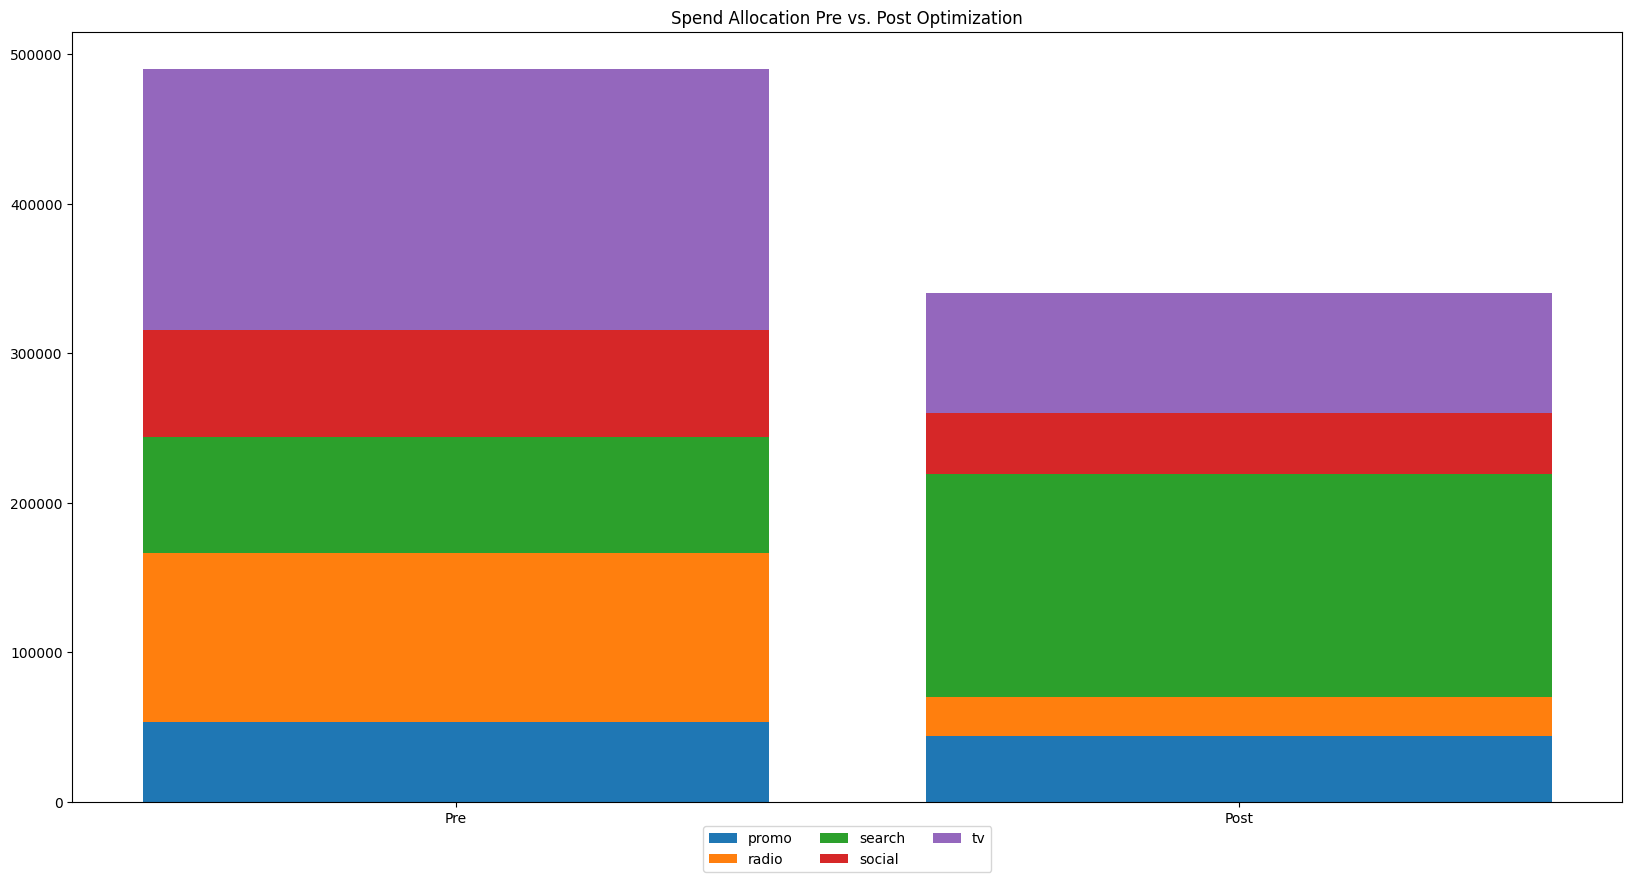

In [12]:
init_total_spend = np.sum(init_spend_matrix, 0)
optim_total_spend = np.sum(optim_spend_matrix, 0)
plot_data = np.vstack([init_total_spend, optim_total_spend])
plot_data.shape

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
bottom = 0.0
for idx, label in enumerate(optim_channels):
    ax.bar(x=["Pre", "Post"], height=plot_data[:, idx], bottom=bottom, label=label)
    bottom += plot_data[:, idx]
ax.set_title("Spend Allocation Pre vs. Post Optimization")
ax.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.10),
    ncol=math.ceil(len(optim_channels) / 2),
);

### Validation

#### Average and Marginal Cost Change

In general, one should expect when LTV is greater than the marginal cost under the pre-optimized spend, there should be an increase of spend in the optimal budget. 

In [13]:
df = mmm.get_raw_df()

In [14]:
cost_report = generate_cost_report(
    model=mmm,
    channels=optim_channels,
    start=budget_start,
    end=budget_end,
    pre_spend_df=df,
    post_spend_df=optim_spend_df,
)
cost_report["ltv"] = ltv_arr
cost_report

,pre-opt-avg-cost,post-opt-avg-cost,pre-opt-marginal-cost,post-opt-marginal-cost,pre-opt-spend,post-opt-spend,ltv
promo,38.86283,34.70033,42.87664,39.84202,53.30000,43.79825,48.50000
radio,79.55461,47.44148,88.34060,52.14919,112.97900,26.41772,52.50000
search,21.24898,28.00029,23.17861,31.74731,78.03300,148.82367,38.60000
social,40.12583,31.78387,43.79484,35.28401,71.64400,41.32094,35.80000
tv,65.72122,47.12829,71.33880,52.15101,174.55200,80.30824,60.80000


In [16]:
pre_mc = cost_report["pre-opt-marginal-cost"].values
overspend = pre_mc > (cost_report["ltv"].values * 1.2)
underspend = pre_mc < (cost_report["ltv"].values * 0.8)
spend_delta = cost_report["post-opt-spend"].values - cost_report["pre-opt-spend"].values
assert np.all(spend_delta[overspend] < 0)
assert np.all(spend_delta[underspend] > 0)

After all, a general condition of marginal cost lower than LTV should be met when spend > 0.

In [17]:
post_mc = cost_report["post-opt-marginal-cost"].values

In [18]:
assert np.all(post_mc < cost_report["ltv"].values * 1.1)

#### Marginal Attribution Check 

Because this optimization is dependent on the attribution logic, another validation can be done by deriving a marginal revenue based on attribution. First, compute the baseline revenue in the current spend condition.

In [19]:
attr_obj = Attributor(
    mmm,
    attr_regressors=optim_channels,
    start=budget_start,
    end=budget_end,
    df=optim_spend_df,
)
res = attr_obj.make_attribution()

_, spend_attr_df, spend_df, _ = res
base_spend_attr_matrix = np.sum(spend_attr_df[optim_channels].values, 0)
base_spend_matrix = np.sum(spend_df[optim_channels].values, 0)
base_rev = base_spend_attr_matrix * (ltv_arr)
base_net_arr = base_rev - base_spend_matrix
baseline_net_rev = base_net_arr.sum()

In [20]:
baseline_net_rev

105091.12891673035

`base_net_arr` now holds net returns for each channel. `baseline_net_rev` holds the total baseline net returns.

Now, one can iteratively simulate scenarios for each channel with additional spend and derive the delta of net returns between the scenario and the baseline.

In [21]:
input_mask = (optim_spend_df["date"] >= budget_start) & (
    optim_spend_df["date"] <= budget_end
)

In [22]:
delta = 1e-1

In [23]:
new_net_revs = np.empty(len(optim_channels))
for idx, ch in enumerate(optim_channels):
    new_spend_df = deepcopy(optim_spend_df)
    delta_matrix = np.zeros_like(new_spend_df.loc[input_mask, optim_channels])
    delta_matrix[:, idx] += delta
    new_spend_df.loc[input_mask, optim_channels] += delta_matrix
    attr_obj = Attributor(
        mmm,
        attr_regressors=optim_channels,
        start=budget_start,
        end=budget_end,
        df=new_spend_df,
    )
    res = attr_obj.make_attribution()
    _, spend_attr_df, spend_df, _ = res
    new_spend_attr_matrix = np.sum(spend_attr_df[optim_channels].values, 0)
    new_spend_matrix = np.sum(spend_df[optim_channels].values, 0)
    new_rev = new_spend_attr_matrix * (ltv_arr)
    new_net_arr = new_rev - new_spend_matrix
    new_net_revs[idx] = new_net_arr.sum()

Now, `new_net_revs` net returns of each scenario with small incremental of spend of such channel.

In [24]:
new_net_revs - baseline_net_rev

array([-0.68660137, -0.41791017, -0.87957558, -0.75839129, -0.34261588])

Users should see negative delta for all scenarios.

### Run optimization with an additional constraint

`.generate_individual_channel_constraints()` is designed to help to generate convenient invidiaul budget constraints with respect to the total budget. For example, by specifying `delta=0.2`, one should expect the total resulting spend of the channel will be within $\pm 20 \%$ of the original budget.

In [ ]:
# maximizer2 = RevenueMaximizer(
#     ltv_arr=ltv_arr,
#     model=mmm,
#     optim_channel=optim_channels,
#     budget_start=budget_start,
#     budget_end=budget_end,
#     spend_scaler=10.0,
# )

# ind_constraints = maximizer2.generate_individual_channel_constraints(delta=0.2)
# maximizer2.add_constraints(ind_constraints)
# optim_spend_df2 = maximizer2.optimize(maxiter=1000, eps=1e-3)

# new_cost_report = generate_cost_report(
#     model=mmm,
#     channels=optim_channels,
#     start=budget_start,
#     end=budget_end,
#     pre_spend_df=df,
#     post_spend_df=optim_spend_df2,
# )
# new_cost_report["ltv"] = ltv_arr
# new_cost_report

In [7]:
import pytest
import numpy as np
import pandas as pd
from copy import deepcopy

from karpiu.models import MMM
from karpiu.simulation import make_mmm_daily_data
from karpiu.planning.optim import ChannelNetProfitMaximizer, TimeNetProfitMaximizer
from karpiu.planning.common import generate_cost_report
from karpiu.explainability import AttributorBeta as Attributor

In [9]:
# data_args
seed = 2022
n_steps = 365 * 3
channels_coef = [0.053, 0.08, 0.19, 0.125, 0.1]
channels = ["promo", "radio", "search", "social", "tv"]
features_loc = np.array([2000, 5000, 3850, 3000, 7500])
features_scale = np.array([550, 2500, 500, 1000, 3500])
scalability = np.array([3.0, 1.25, 0.8, 1.3, 1.5])
start_date = "2019-01-01"
adstock_args = {
    "n_steps": 28,
    "peak_step": np.array([10, 8, 5, 3, 2]),
    "left_growth": np.array([0.05, 0.08, 0.1, 0.5, 0.75]),
    "right_growth": np.array([-0.03, -0.6, -0.5, -0.1, -0.25]),
}
best_params = {
    "damped_factor": 0.9057,
    "level_sm_input": 0.00245,
}
ltv_arr = [48.5, 52.5, 38.6, 35.8, 60.8]
np.random.seed(seed)

df, scalability_df, adstock_df, event_cols = make_mmm_daily_data(
    channels_coef=channels_coef,
    channels=channels,
    features_loc=features_loc,
    features_scale=features_scale,
    scalability=scalability,
    n_steps=n_steps,
    start_date=start_date,
    adstock_args=adstock_args,
    with_yearly_seasonality=True,
    with_weekly_seasonality=True,
    country="US",
)

mmm = MMM(
    kpi_col="sales",
    date_col="date",
    spend_cols=channels,
    event_cols=event_cols,
    seed=seed,
    adstock_df=adstock_df,
    seasonality=[7, 365.25],
    fs_orders=[2, 3],
)
mmm.derive_saturation(df=df, scalability_df=scalability_df)
mmm.set_hyper_params(params=best_params)
# need this 4000/4000 to make sure coefficients are converged
mmm.fit(df, num_warmup=4000, num_sample=4000, chains=4)
budget_start = "2020-01-01"
budget_end = "2020-01-31"
optim_channels = mmm.get_spend_cols()
# to be safe in beta version, use sorted list of channels
optim_channels.sort()

2023-03-26 17:02:47 - karpiu-mmm - INFO - Initialize model
2023-03-26 17:02:47 - karpiu-mmm - INFO - Deriving saturation constants...
2023-03-26 17:02:47 - karpiu-mmm - INFO - Derived saturation constants.
2023-03-26 17:02:47 - karpiu-mmm - INFO - Set hyper-parameters.
2023-03-26 17:02:47 - karpiu-mmm - INFO - Best params damped_factor set as 0.90570
2023-03-26 17:02:47 - karpiu-mmm - INFO - Best params level_sm_input set as 0.00245
2023-03-26 17:02:47 - karpiu-mmm - INFO - Fit final model.
2023-03-26 17:02:47 - karpiu-mmm - INFO - Build a default regression scheme
2023-03-26 17:02:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 1000.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-03-26 17:07:34 - karpiu-mmm - INFO - Spend channels regression coefficients sum (0.5017367) is within common range (0, 0.8].


Optimization terminated successfully    (Exit mode 0)
            Current function value: 651948.1707830045
            Iterations: 52
            Function evaluations: 312
            Gradient evaluations: 52
Optimization terminated successfully    (Exit mode 0)
            Current function value: 651948.1707830045
            Iterations: 52
            Function evaluations: 312
            Gradient evaluations: 52


AssertionError: 

In [57]:
ch_npm = ChannelNetProfitMaximizer(
    ltv_arr=ltv_arr,
    model=mmm,
    budget_start=budget_start,
    budget_end=budget_end,
    optim_channels=optim_channels,
)
temp_optim_spend_df = ch_npm.optimize(maxiter=1000)
ch_npm_curr_state = ch_npm.get_current_state()
ch_npm_init_state = ch_npm.get_init_state()

# check: optimization result should be indifferent with initial values
# create different initial spend df and plug back into the model
new_raw_df = mmm.get_raw_df()
new_spend_matrix = np_shuffle(
    new_raw_df.loc[
        (new_raw_df["date"] >= budget_start) & (new_raw_df["date"] <= budget_end),
        optim_channels,
    ].values
)
new_raw_df.loc[
    (new_raw_df["date"] >= budget_start) & (new_raw_df["date"] <= budget_end),
    optim_channels,
] = new_spend_matrix

new_mmm = deepcopy(mmm)
new_mmm.raw_df = new_raw_df
new_ch_npm = ChannelNetProfitMaximizer(
    ltv_arr=ltv_arr,
    model=new_mmm,
    budget_start=budget_start,
    budget_end=budget_end,
    optim_channels=optim_channels,
)
_ = new_ch_npm.optimize(maxiter=1000)
new_ch_npm_curr_state = new_ch_npm.get_current_state()
new_ch_npm_init_state = new_ch_npm.get_init_state()

# the final result should be closed in either by 1e-1 or .1%
assert np.any(np.not_equal(new_ch_npm_init_state, ch_npm_init_state))
assert np.allclose(new_ch_npm_curr_state, ch_npm_curr_state, atol=1e-1, rtol=1e-3)

temp_mmm = deepcopy(mmm)
temp_mmm.raw_df = temp_optim_spend_df

# pass into time budget optimizer
t_npm = TimeNetProfitMaximizer(
    ltv_arr=ltv_arr,
    model=temp_mmm,
    budget_start=budget_start,
    budget_end=budget_end,
    optim_channels=optim_channels,
)
optim_spend_df = t_npm.optimize(maxiter=1000)

cost_report = generate_cost_report(
    model=mmm,
    channels=optim_channels,
    start=budget_start,
    end=budget_end,
    pre_spend_df=df,
    post_spend_df=optim_spend_df,
)
cost_report["ltv"] = np.array(ltv_arr)

# check general cost report condition
pre_opt_spend = cost_report["pre-opt-spend"].values
pre_ac = cost_report["pre-opt-avg-cost"].values[pre_opt_spend > 0]
pre_mc = cost_report["pre-opt-marginal-cost"].values[pre_opt_spend > 0]

post_opt_spend = cost_report["post-opt-spend"].values
post_ac = cost_report["post-opt-avg-cost"].values[post_opt_spend > 0]
post_mc = cost_report["post-opt-marginal-cost"].values[post_opt_spend > 0]

assert np.all(pre_mc >= pre_ac)
assert np.all(post_mc >= post_ac)

# check 3: underspend and overspend condition can be checked by
# whether pre_mc > ltv (overspend) and vice versa
pre_mc = cost_report["pre-opt-marginal-cost"].values
post_avg_mc = cost_report["post-opt-avg-cost"].values
positive_spend = cost_report["post-opt-spend"]
overspend = pre_mc > (cost_report["ltv"].values * 1.2)
underspend = pre_mc < (cost_report["ltv"].values * 0.8)
spend_delta = cost_report["post-opt-spend"].values - cost_report["pre-opt-spend"].values
assert np.all(spend_delta[overspend] < 0)
assert np.all(spend_delta[underspend] > 0)

# check 4: post-mc should be close or under ltv; post-avg-cost should be
# lower than ltv when they have spend
# 1.2 is pretty high tolerance; but it may be okay for a unit test
post_mc = cost_report["post-opt-marginal-cost"].values
assert np.all(
    post_mc[positive_spend > 0] < cost_report["ltv"].values[positive_spend > 0] * 1.2
)
assert np.all(
    post_avg_mc[positive_spend > 0]
    < cost_report["ltv"].values[positive_spend > 0] * 1.1
)

# check 5: all the marginal net return should be negative if a small delta is added to the current budget plan
attr_obj = Attributor(
    mmm,
    attr_regressors=optim_channels,
    start=budget_start,
    end=budget_end,
    df=optim_spend_df,
)
res = attr_obj.make_attribution()

_, spend_attr_df, spend_df, _ = res
base_spend_attr_matrix = np.sum(spend_attr_df[optim_channels].values, 0)
base_spend_matrix = np.sum(spend_df[optim_channels].values, 0)
base_rev = base_spend_attr_matrix * (ltv_arr)
base_net_arr = base_rev - base_spend_matrix
baseline_net_rev = base_net_arr.sum()
input_mask = attr_obj.input_mask
delta = 1e-1

new_net_revs = np.empty(len(optim_channels))
for idx, ch in enumerate(optim_channels):
    new_spend_df = deepcopy(optim_spend_df)
    delta_matrix = np.zeros_like(new_spend_df.loc[input_mask, optim_channels])
    delta_matrix[:, idx] += delta
    new_spend_df.loc[input_mask, optim_channels] += delta_matrix
    attr_obj = Attributor(
        mmm,
        attr_regressors=optim_channels,
        start=budget_start,
        end=budget_end,
        df=new_spend_df,
    )
    res = attr_obj.make_attribution()
    _, spend_attr_df, spend_df, _ = res
    new_spend_attr_matrix = np.sum(spend_attr_df[optim_channels].values, 0)
    new_spend_matrix = np.sum(spend_df[optim_channels].values, 0)
    new_rev = new_spend_attr_matrix * (ltv_arr)
    new_net_arr = new_rev - new_spend_matrix
    new_net_revs[idx] = new_net_arr.sum()

assert np.all(new_net_revs - baseline_net_rev < 0)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 651947.3725562743
            Iterations: 70
            Function evaluations: 422
            Gradient evaluations: 70
Optimization terminated successfully    (Exit mode 0)
            Current function value: 651947.3725562422
            Iterations: 71
            Function evaluations: 428
            Gradient evaluations: 71
Optimization terminated successfully    (Exit mode 0)
            Current function value: 644226.6041273522
            Iterations: 46
            Function evaluations: 1475
            Gradient evaluations: 46


In [55]:
new_ch_npm_init_state

array([ 55323., 123916.,  94991.,  70182., 185884.])

In [56]:
ch_npm_init_state

array([ 55323., 123916.,  94991.,  70182., 185884.])

In [43]:
ch_npm = ChannelNetProfitMaximizer(
    ltv_arr=ltv_arr,
    model=mmm,
    budget_start=budget_start,
    budget_end=budget_end,
    optim_channels=optim_channels,
)
temp_optim_spend_df = ch_npm.optimize(maxiter=1000, ftol=1e-7)
ch_npm_curr_state = ch_npm.get_current_state()
ch_npm_init_state = ch_npm.get_init_state()
ch_npm_init_spend_matrix = ch_npm.get_init_spend_matrix()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 651947.3725562743
            Iterations: 70
            Function evaluations: 422
            Gradient evaluations: 70


In [44]:
ch_npm_init_spend_matrix

array([[ 2000.,  6495.,     0.,  2892.,  6716.],
       [ 3420.,  7480.,  3626.,     0., 11097.],
       [ 1279.,  1410.,  2963.,  3048.,  8106.],
       [  948.,  4102.,     0.,     0.,  5707.],
       [ 1785.,  7424.,     0.,  1823.,  4392.],
       [ 2299.,  7033.,  3416.,     0.,  4100.],
       [ 1106.,  5886.,  3725.,  2881.,  9518.],
       [ 1715.,  4360.,  3660.,  2305.,  8577.],
       [ 1182.,  5958.,  3877.,  2585.,  9014.],
       [ 2756.,     0.,  3792.,  2215.,  1891.],
       [ 1802.,     0.,  3568.,  1013.,  7443.],
       [ 2628.,  6053.,  3363.,  3870.,    22.],
       [    0.,  7960.,  4287.,  2815., 10489.],
       [ 1951.,  5831.,     0.,  1399.,  9058.],
       [ 2688.,  6449.,  3520.,  2136.,   930.],
       [ 1910.,  1133.,  4402.,  2866.,     0.],
       [ 1910.,  4754.,  3846.,  1912.,  8228.],
       [ 1936.,  5171.,  4078.,  3652.,     0.],
       [    0.,  5397.,     0.,   973.,     0.],
       [ 2140.,     0.,  3946.,  3843.,  8236.],
       [ 3003.,  506

In [35]:
from karpiu.utils import np_shuffle

In [45]:
# check: optimization result should be indifferent with initial values
# create different initial spend df and plug back into the model
new_raw_df = mmm.get_raw_df()
new_spend_matrix = np_shuffle(
    new_raw_df.loc[
        (new_raw_df["date"] >= budget_start) & (new_raw_df["date"] <= budget_end),
        optim_channels,
    ].values
)
# mutable numpy array; shuffle only works on the first axis so
# flatten it first

new_raw_df.loc[
    (new_raw_df["date"] >= budget_start) & (new_raw_df["date"] <= budget_end),
    optim_channels,
] = new_spend_matrix
new_mmm = deepcopy(mmm)
new_mmm.raw_df = new_raw_df
new_ch_npm = ChannelNetProfitMaximizer(
    ltv_arr=ltv_arr,
    model=new_mmm,
    budget_start=budget_start,
    budget_end=budget_end,
    optim_channels=optim_channels,
)
_ = new_ch_npm.optimize(maxiter=1000, ftol=1e-7)
new_ch_npm_curr_state = new_ch_npm.get_current_state()
new_ch_npm_init_state = new_ch_npm.get_init_state()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 651947.3725562561
            Iterations: 58
            Function evaluations: 351
            Gradient evaluations: 58


In [51]:
new_ch_npm_curr_state

array([     0.     ,  37648.90463, 194641.18489, 119362.53897,
        35679.37612])

In [52]:
ch_npm_curr_state

array([     0.     ,  37648.92683, 194641.25978, 119362.45468,
        35679.4359 ])

In [48]:
# the final result should be closed in either by 1e-1 or .1%
assert np.any(np.not_equal(new_ch_npm_init_state, ch_npm_init_state))
assert np.allclose(new_ch_npm_curr_state, ch_npm_curr_state, atol=1e-1, rtol=1e-3)

In [49]:
new_ch_npm_init_state

array([100629.,  91077., 122494., 103961., 112135.])

In [50]:
new_ch_npm_curr_state

array([     0.     ,  37648.90463, 194641.18489, 119362.53897,
        35679.37612])

In [19]:
budget_start = "2020-01-01"
budget_end = "2020-01-31"
optim_channels = mmm.get_spend_cols()
# to be safe in beta version, use sorted list of channels
optim_channels.sort()

ch_npm = ChannelNetProfitMaximizer(
    ltv_arr=ltv_arr,
    model=mmm,
    budget_start=budget_start,
    budget_end=budget_end,
    optim_channels=optim_channels,
)
temp_optim_spend_df = ch_npm.optimize(maxiter=1000)
temp_mmm = deepcopy(mmm)
temp_mmm.raw_df = temp_optim_spend_df

t_npm = TimeNetProfitMaximizer(
    ltv_arr=ltv_arr,
    model=temp_mmm,
    budget_start=budget_start,
    budget_end=budget_end,
    optim_channels=optim_channels,
    variance_penalty=1e-5,
)
optim_spend_df = t_npm.optimize(maxiter=1000)

cost_report = generate_cost_report(
    model=mmm,
    channels=optim_channels,
    start=budget_start,
    end=budget_end,
    pre_spend_df=df,
    post_spend_df=optim_spend_df,
)
cost_report["ltv"] = np.array(ltv_arr)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 651948.1707830045
            Iterations: 52
            Function evaluations: 312
            Gradient evaluations: 52
Optimization terminated successfully    (Exit mode 0)
            Current function value: 623309.973052401
            Iterations: 208
            Function evaluations: 6656
            Gradient evaluations: 208


In [20]:
cost_report

,pre-opt-avg-cost,post-opt-avg-cost,pre-opt-marginal-cost,post-opt-marginal-cost,pre-opt-spend,post-opt-spend,ltv
promo,98.630855,NaN,113.247940,84.874641,55.323,0.000000,48.5
radio,79.015407,49.970755,91.017909,54.887653,123.916,37.652974,52.5
search,22.278224,29.249047,25.792667,37.267119,94.991,195.013185,38.6
social,26.868558,30.941554,30.811094,37.665445,70.182,118.859566,35.8
tv,91.454026,52.478514,107.762451,65.146484,185.884,35.697312,60.8


In [9]:
t_npm.get_current_state()

array([[   59.40806,   140.26406,   229.37471,   174.27444,   212.75162],
       [ 5940.80645, 14026.4057 , 22937.47062, 17427.44444, 21275.16174],
       [   59.40807,   140.26406,   229.37471,   174.27445,   212.75162],
       [   59.40806,   140.26406,   229.37471,   174.27444,   212.75162],
       [   59.40806,   140.26406,   229.37471,   174.27444,   212.75162],
       [   59.40806,   140.26406,   229.37471,   174.27444,   212.75162],
       [   59.40806,   140.26406,   229.37471,   174.27444,   212.75162],
       [   59.40806,   140.26406,   229.37471,   174.27444,   212.75162],
       [ 2696.07557,  6365.50778, 10409.55544,  7908.97794,  9655.16117],
       [ 2711.6612 ,  6402.30589, 10469.73163,  7954.69863,  9710.9763 ],
       [  534.7735 ,  1262.61478,  2064.76199,  1568.76604,  1915.12596],
       [   59.40806,   140.26406,   229.37471,   174.27444,   212.75162],
       [   59.40806,   140.26406,   229.37471,   174.27444,   212.75162],
       [   59.40806,   140.26406,   22